In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from PIL import Image

from train.transforms import LocsToHeatmaps, AffineCrop
from utils.img_utils import draw_kpts
from bop_dataset import BOPDataset

In [2]:
# Visualize objects: objid=1
all_objid = [1, 5, 6, 8, 9, 10, 11, 12]
show_objid = [5]

dataset = BOPDataset('data/bop', 'lmo', split='test', valid_objid=show_objid)


# 3D keypoint annotation on CAD models
with open('kpts3d.json', 'r') as infile:
    kpts3d = json.load(infile)['lmo']

### Compute 2D keypoints

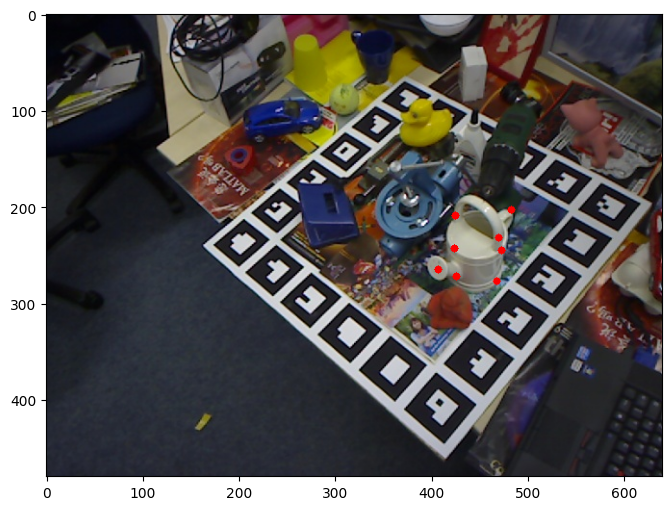

In [3]:
i =20
meta = dataset.db[i]

imgfile = meta['imgpath']
image = np.array(Image.open(imgfile))

# 6d pose from offical dataset
obj_id = meta['obj_id']
R = meta['R']
t = meta['t']
K = meta['K']

# 3D keypoints for the correspoinding object
obj_kpts3d = np.array(kpts3d[str(obj_id)])

# Projection
kpts_3d = (R @ obj_kpts3d.T).T + t
kpts_2d = (K @ kpts_3d.T).T
kpts_2d = kpts_2d[:,:2]/kpts_2d[:,[2]]

img = draw_kpts(image.copy(), kpts_2d, r=1)

plt.rcParams['figure.figsize'] = 8,6
plt.imshow(img)

### 2D keypoints by dataset class
The previous demo steps are implemented in the BOPDataset class already.

In [4]:
transform_list = [AffineCrop(out_size=256, scale_factor=0., rotation_factor=0, dialation=0.25),
                 LocsToHeatmaps(out_size=(64, 64))]
transform = transforms.Compose(transform_list)

dataset = BOPDataset('data/bop', 'lmo', split='test', 
                     return_keypoints=True, transform=transform,
                     valid_objid=show_objid)

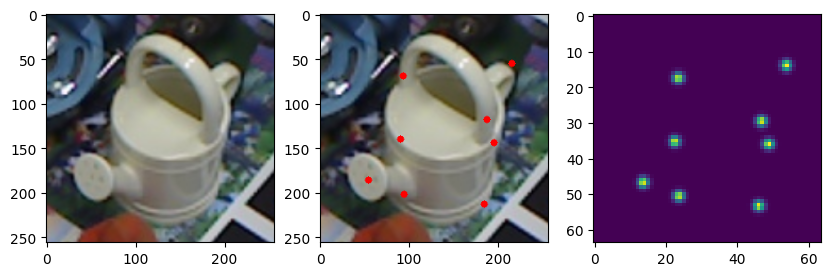

In [5]:
# 2D keypoints are computed by the BOP dataset class
i =20
sample = dataset[i]
img = np.array(sample['image'])

kpts = sample['keypoints']
vis = sample['visible_keypoints'] > 0
kpts_vis = kpts[vis]
img_kpts = draw_kpts(img, kpts_vis, r=1, thickness=5)

vis_heatmaps = sample['keypoint_heatmaps'][:,:,vis]
heatmap = vis_heatmaps.sum(axis=-1)


plt.rcParams['figure.figsize']=10,8
plt.subplot(1,3,1)
plt.imshow(img)
plt.subplot(1,3,2)
plt.imshow(img_kpts)
plt.subplot(1,3,3)
plt.imshow(heatmap)